In [85]:
import pandas as pd
# pd.set_option("max_columns", 200)
import numpy as np
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import gzip

from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()

%load_ext autoreload
%autoreload 2

# Meus pacotes
from pm_tools import parse_mxml as pm
from pm_tools import log_representation as lr
from pm_tools import plots as plts
from pm_tools import model_utils as mu
from pm_tools import drift_detection as dd
from pm_tools import offline_streaming_clustering as off_sc

from scipy.spatial import distance
from sklearn.base import clone as sk_clone 
import traceback 
from sklearn.model_selection import ParameterGrid

from copy import deepcopy
import random
random.seed(42)
import os
import re
import warnings
warnings.filterwarnings("ignore")

import glob

from sklearn.cluster import KMeans, AgglomerativeClustering
from joblib import Parallel, delayed, parallel_backend

import gc
gc.enable()

aliases = {
    'Loan__application_received': 'START',
    'Appraise_property': 'A',
    'Approve_application': 'B',
    'Assess_eligibility': 'C',
    'Assess_loan_risk': 'D',
    'Cancel_application': 'E',
    'Check__application__form_completeness': 'F',
    'Check_credit_history': 'G',
    'Check_if_home_insurance_quote_is_requested': 'H',
    'Prepare_acceptance_pack': 'I',
    'Receive_updated_application': 'J',
    'Reject_application': 'K',
    'Return_application_back_to_applicant': 'L',
    'Send_acceptance_pack': 'M',
    'Send_home_insurance_quote': 'N',
    'Verify_repayment_agreement': 'O',
    'Loan__application_approved': 'END_A',
    'Loan_application_rejected': 'END_R',
    'Loan__application_canceled': 'END_C',
}

inv_aliases = {v: k for k, v in aliases.items()}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def insensitive_glob(pattern):
    def either(c):
        return '[%s%s]' % (c.lower(), c.upper()) if c.isalpha() else c
    return glob.glob(''.join(map(either, pattern)))

def if_any(string, lista):
    for l in lista:
        if l in string:
            return True
    return False

In [3]:
logs = insensitive_glob("process_mining_datasets/*/*k.MXML")
logs = [x for x in logs if "2.5" not in x]

In [63]:
objects = {
    "model": {
        "kmeans__k=12": KMeans(n_clusters=12, random_state=42),
        "kmeans__k=8": KMeans(n_clusters=8, random_state=42),
        "kmeans__k=6": KMeans(n_clusters=6, random_state=42),
        "kmeans__k=5": KMeans(n_clusters=5, random_state=42),
        "kmeans__k=4": KMeans(n_clusters=4, random_state=42),
        "kmeans__k=3": KMeans(n_clusters=3, random_state=42),
        "kmeans__k=2": KMeans(n_clusters=2, random_state=42),
    },
    
    "representation": {
        "binary": lambda x: lr.get_binary_representation(lr.get_traces_as_tokens(x)),
        "frequency": lambda x: lr.get_frequency_representation(lr.get_traces_as_tokens(x)),
        "tfidf": lambda x: lr.get_tfidf_representation(lr.get_traces_as_tokens(x)),
        "transitions": lambda x: lr.get_binary_transitions_representation(lr.get_traces_as_tokens(x)),
        "positions": lambda x: lr.get_positions_representation(lr.get_traces_as_tokens(x)),
        "positions_min_max": lambda x: lr.get_min_max_positions_representation(lr.get_traces_as_tokens(x)),
        "positions_avg": lambda x: lr.get_positions_representation(lr.get_traces_as_tokens(x), include_cols=["_avg"]),
        "activities_order_normalized": lambda x: lr.get_activities_order_representation(lr.get_traces_as_tokens(x)),
        "activities_pair_distance_normalized": lambda x: lr.get_activities_pair_distance_representation(lr.get_traces_as_tokens(x)),
    }
}

In [64]:
binary_support = ["cb", "cf",  "cm", "rp", "pm", "fr"]
frequency_support = binary_support + ['lp', 'cp', ]
transitions_support = frequency_support + ["pl", "cd", "sw"]
composite = ['RIO', 'ROI', 'ORI', 'OIR', 'IRO', 'IOR']

### Pipeline Offline Clustering

In [6]:
OUTPUT_PATH = "C:/Users/rafae/Downloads/LoanApplications_Offline/"

In [7]:
logs_composite = [x for x in logs if if_any(x, composite)]

In [52]:
def read_file_and_run_clustering_pipeline(args, return_ = False):
    # Tratamento do caminho do arquivo para estruturar nomes
    # e tamanho do log
    split = args["log"].split("\\")

    cd_name = split[1]
    log_name = split[2][:-5]

    log_size = log_name.replace(cd_name, "").replace("new_", "")
    try:
        log_size = int(float(log_size.replace("k", "")) * 1000)
        # Monta o vetor de resposta
        y_true = [x for x in range(int(log_size/10), log_size, int(log_size/10))]
    except:
        log_size = 3000
        y_true = [890, 1890]
    
    try:
        # Lê o log e aplica a representação
        if 'gzip' in args["log"]:
            log_read = pm.all_prep(gzip.open(args["log"]), aliases)
        else:
            log_read = pm.all_prep(open(args["log"]), aliases)
            
        df = objects["representation"][args["representation"]](
            log_read
        )
        
        col_names = df.columns
        
        for p in args["parameters"]:
            # String para identificação da memória cache
            tipo_mudanca = cd_name.replace("new_", "")
            
            cached_info = "_".join([
                tipo_mudanca,
                str(log_size),
                p["model"],
                args["representation"],
                str(p["window_size"]),
                str(p["sliding_window"])
            ])
            
            print(cached_info)
            
            # If already exists, skip
            if os.path.exists(OUTPUT_PATH + tipo_mudanca + '/' + cached_info + '.pickle.gzip'):
                if return_:
                    r_ = pd.read_pickle(OUTPUT_PATH + tipo_mudanca + '/' + cached_info + '.pickle.gzip', compression='gzip')
                    r_.centroids = r_.centroids.apply(lambda x: pd.DataFrame(x, columns=col_names))
                    r_.diff_centroids = r_.diff_centroids.apply(
                        lambda x: pd.DataFrame(x, columns=col_names) if not np.isnan(x).any() else np.nan
                    )
                    r_['sum_diff_centroids'] = r_['diff_centroids'].apply(
                        lambda x: np.abs(x.sum(axis=0)).sum() if not x is np.nan else np.nan
                    )
                    return r_
                else:
                    continue
            
            run_df, measures_df = off_sc.run_offline_clustering_window(
                sk_clone(objects["model"][p["model"]]),
                p["window_size"],
                df,
                p["sliding_window"],
                sliding_step=p['sliding_step'],
                reuse_centers=p['reuse_centers']
            )
                
            all_metrics = run_df.join(measures_df)
            all_metrics.index += p["window_size"]
            all_metrics.centroids = all_metrics.centroids.apply(lambda x: pd.DataFrame(x, columns=col_names))
            all_metrics.diff_centroids = all_metrics.diff_centroids.apply(
                lambda x: pd.DataFrame(x, columns=col_names) if not np.isnan(x).any() else np.nan
            )
            all_metrics['sum_diff_centroids'] = all_metrics['diff_centroids'].apply(
                lambda x: np.abs(x.sum(axis=0)).sum() if not x is np.nan else np.nan
            )
            
            if return_:
                return all_metrics
            else:
                try:
                    os.makedirs(OUTPUT_PATH + tipo_mudanca + '/')
                except:
                    pass
                all_metrics.to_pickle(OUTPUT_PATH + tipo_mudanca + '/' + cached_info + '.pickle.gzip', compression="gzip")

            # test = pd.read_csv("../offline_window_clustering_results/" + cached_info + ".csv", index_col=0)
            # assert test.shape == all_metrics.shape

            gc.collect()

            # return all_metrics
    except Exception as e:
        traceback.print_exc()

In [50]:
all_metrics = read_file_and_run_clustering_pipeline({
    'log': 'process_mining_datasets\\fr\\fr10k.mxml',
    'representation': 'binary',
    'parameters': [{
        'model': 'kmeans__k=3', 
        'sliding_window': False,
        'window_size': 125,
        'sliding_step': 1,
        'reuse_centers': True
    }]
}, return_=True)

fr_10000_kmeans__k=3_binary_125_False


In [146]:
dfs = []

for k in [
    2, 3, 4, 5, 6
]:
    x = read_file_and_run_clustering_pipeline({
            'log': 'process_mining_datasets\\fr\\fr5k.mxml',
            'representation': 'binary',
            'parameters': [{
                'model': 'kmeans__k=' + str(k), 
                'sliding_window': False,
                'window_size': 150,
                'sliding_step': 1,
                'reuse_centers': True
            }]
        }, return_=True).add_suffix("__" + str(k))
    x.index += x.index[1]
    dfs.append(x)

fr_5000_kmeans__k=2_binary_150_False
fr_5000_kmeans__k=3_binary_150_False
fr_5000_kmeans__k=4_binary_150_False
fr_5000_kmeans__k=5_binary_150_False
fr_5000_kmeans__k=6_binary_150_False


In [147]:
dfs_ = dfs[1]

In [148]:
dfs_.corr()['avg_dist_between_centroids__3'].abs().sort_values()

std_diff_centroids__3                       0.000002
diff_skewness__3                            0.028968
diff_std_dist_between_sq_sums__3            0.033751
sum_diff_centroids__3                       0.034173
diff_cluster_std__3                         0.048490
std_diff_squared_sum__3                     0.060252
std_dist_between_sq_sums__3                 0.075019
std_radius__3                               0.078233
avg_MSE__3                                  0.091778
total_MSE__3                                0.091778
count_non_zero_MSE__3                       0.094064
std_squared_sum__3                          0.097032
avg_dist_between_sq_sums__3                 0.097159
diff_squared_sum__3                         0.132833
diff_avg_dist_between_sq_sums__3            0.159277
std_skewness__3                             0.164735
min_dist_between_centroids__3               0.168833
diff_sum_squared_sum__3                     0.228563
sum_squared_sum__3                          0.

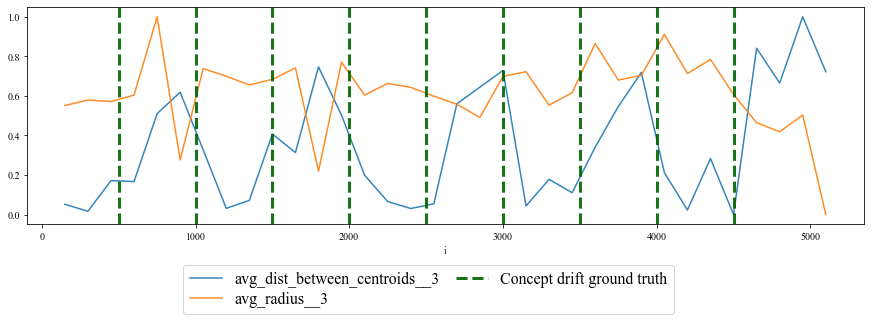

In [158]:
#dfs__ = dfs_[[x for x in dfs_.columns if x.startswith('avg_dist_between_centroids')]]
dfs__  = dfs_[['avg_dist_between_centroids__3', 'avg_radius__3']]
dfs__ = dfs__.fillna(method='bfill')
# dfs__['mean_'] = dfs__.median(axis=1)

dfs__ = pd.DataFrame(minmax.fit_transform(dfs__), columns=dfs__.columns, index=dfs__.index)

dfs__.plot(figsize=(15,4), alpha=0.9)
plts.plot_drift_vertical_lines(5000)
plt.legend(fontsize=32, loc='upper center', bbox_to_anchor=(0.48, -0.15),
              fancybox=True, shadow=False, prop={"family":"Times New Roman", "size":"16"},
              frameon=True, ncol=2, labelspacing=0.25, columnspacing=1)

In [ ]:
dfs__ = dfs_[[x for x in dfs_.columns if x.startswith('total_MSE')]]
dfs__ = dfs__.fillna(method='ffill')
dfs__['mean_'] = dfs__.mean(axis=1)
dfs__.plot(figsize=(15,4), alpha=0.9)
plts.plot_drift_vertical_lines(5000)
plt.legend(fontsize=32, loc='upper center', bbox_to_anchor=(0.48, -0.15),
              fancybox=True, shadow=False, prop={"family":"Times New Roman", "size":"16"},
              frameon=True, ncol=2, labelspacing=0.25, columnspacing=1)

In [898]:
all_metrics_t = read_file_and_run_clustering_pipeline(args, return_=True)

fr_10000_kmeans__k=3_transitions_125_False


In [928]:
all_metrics_f = read_file_and_run_clustering_pipeline({
    'log': 'process_mining_datasets\\fr\\fr10k.mxml',
    'representation': 'frequency',
    'parameters': [{
        'model': 'kmeans__k=3', 
        'sliding_window': False,
        'window_size': 125,
        'sliding_step': 1,
        'reuse_centers': True
    }]
}, return_=True)

fr_10000_kmeans__k=3_frequency_125_False


In [906]:
all_metrics_a = read_file_and_run_clustering_pipeline({
    'log': 'process_mining_datasets\\fr\\fr10k.mxml',
    'representation': 'activities_order_normalized',
    'parameters': [{
        'model': 'kmeans__k=3', 
        'sliding_window': False,
        'window_size': 125,
        'sliding_step': 1,
        'reuse_centers': True
    }]
}, return_=True)

fr_10000_kmeans__k=3_activities_order_normalized_125_False


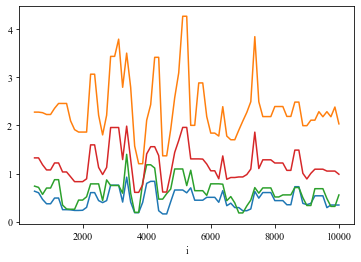

In [930]:
all_metrics['sum_diff_centroids'].rolling(3).median().plot()
all_metrics_t['sum_diff_centroids'].rolling(3).median().plot()
all_metrics_a['sum_diff_centroids'].rolling(3).median().plot()
all_metrics_f['sum_diff_centroids'].rolling(3).median().plot()

((all_metrics_a['sum_diff_centroids'] + all_metrics_t['sum_diff_centroids'] + all_metrics['sum_diff_centroids'])/3).rolling(3).median().plot()

In [100]:
teste = pd.concat([
    x.to_frame().transpose() if x is not np.nan else pd.DataFrame()
    for x in dfs['diff_centroids__transitions'].apply(lambda x: x.sum().abs() if not x is np.nan else np.nan).tolist()
])
teste.index = dfs.index[1:]

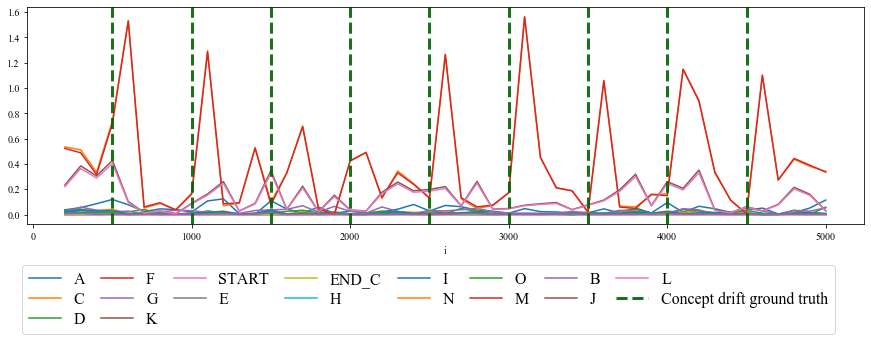

In [96]:
# activities_order_normalized

teste.plot(figsize=(15,4))
plts.plot_drift_vertical_lines(5000)
plt.legend(fontsize=32, loc='upper center', bbox_to_anchor=(0.48, -0.15),
              fancybox=True, shadow=False, prop={"family":"Times New Roman", "size":"16"},
              frameon=True, ncol=8, labelspacing=0.25, columnspacing=1)

In [55]:
teste['total_sum'] = teste.sum(axis=1)

{'Precision': 0.3333333333333333, 'Recall': 0.4444444444444444, 'F1': 0.38095238095238093, 'Delay': 93.75, 'Correct_Predictions': [0, 0, 1, 0, 1, 1, 0, 0, 1], 'Support': 4, 'Drifts_Found': [750, 1750, 2625, 3125, 3875, 4375, 5125, 6125, 6875, 7750, 9000, 9875], 'Resp': [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]}


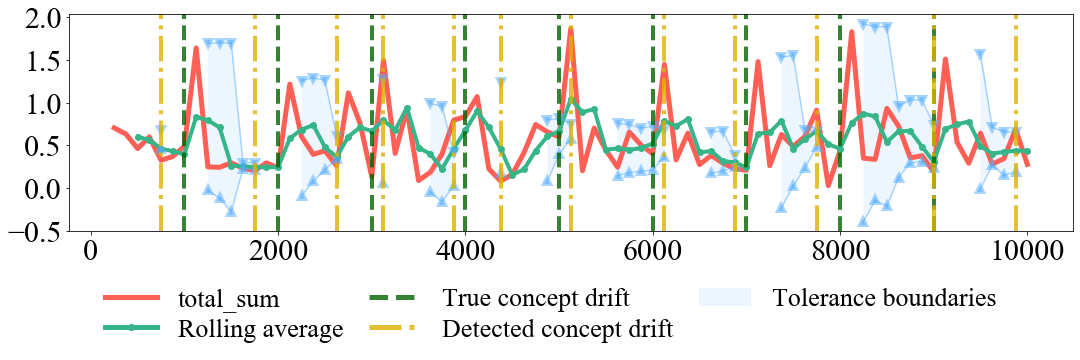

In [60]:
col = "total_sum"
y_true = [x for x in range(int(all_metrics.index[-1]/10), all_metrics.index[-1], int(all_metrics.index[-1]/10))]

drifts_found, info = dd.detect_concept_drift(
    teste, col, rolling_window=3, std_tolerance=1.5, min_tol=0.05, use_median=False
)

plts.plot_deteccao_drift(
    teste,
    col,
    drifts_found,
    y_true,
    info['means'],
    info['lowers'],
    info['uppers'],
    cluster_window_size=int(all_metrics.index[0]),
    save_png=""
)

In [61]:
grid_parameters = list(ParameterGrid({
    "sliding_window": [False],    
    "window_size": [75, 100, 125, 150, 175, 200],
    "model": [
        'kmeans__k=6',
        'kmeans__k=3',
        'kmeans__k=2'
    ] 
}))

grid_logs = list(ParameterGrid([
    {
        "log": [x for x in logs if if_any(x, binary_support)] + logs_composite,
        "representation": ['binary']
    },
    {
        "log": [x for x in logs if if_any(x, frequency_support)] + logs_composite,
        "representation": ['frequency']
    },
    {
        "log": [x for x in logs if if_any(x, transitions_support)] + logs_composite,
        "representation": ['transitions', 'activities_order_normalized', 'activities_pair_distance_normalized']
    }
]))

combs = []
for x in grid_logs:
    dic = x.copy()
    dic['parameters'] = grid_parameters
    
    combs.append(dic)

len(combs), len(grid_parameters), len(combs) * len(grid_parameters) 

(231, 18, 4158)

In [ ]:
final_resp = Parallel(n_jobs=2)(
    delayed(read_file_and_run_clustering_pipeline)(comb) for comb in tqdm_notebook(combs)
)

### Pipeline Detecção

In [10]:
drift_config = list(ParameterGrid([
    {
        "detection_type": ["tradicional", 'mean'],
        "rolling_window": [3, 4, 5],
        "std_tolerance": [1.25, 1.5, 1.75, 2],
        'min_tol': [0.01, 0.007, 0.005, 0.003] 
    }
]))

In [11]:
clusterizacoes = glob.glob(OUTPUT_PATH + "*/*.pickle.gzip")

In [12]:
combs_deteccao = []
for log in clusterizacoes:
    combs_deteccao.append({
        'input': log,
        'combinations': drift_config
    })

In [13]:
def drift_detect_pipeline(args):
    all_metrics = pd.read_pickle(args["input"], compression='gzip')
    
    path_file = args["input"].replace(".pickle.gzip", "").split('\\')
    
    args.update({
        "tipo_mudanca": path_file[-1].split('_')[0],
        "log_size": int(path_file[-1].split('_')[1]),
        "model": "_".join(path_file[-1].split('_')[2:5]),
        "representation": "_".join(path_file[-1].split('_')[5:-2]),
        "window_size": path_file[-1].split('_')[-2],
        "sliding_window": path_file[-1].split('_')[-1]
    })
    
    for combination in args['combinations']:
        c = deepcopy(combination)
        c.update({
            'input': args['input'],
            'tipo_mudanca': args['tipo_mudanca'],
            'log_size': args['log_size'],
            'model': args['model'],
            'representation': args['representation'],
            'window_size': args['window_size'],
            'sliding_window': args['sliding_window']
        })
        
        __drift_detect_pipeline(
            all_metrics, c
        )
    

def __drift_detect_pipeline(all_metrics, args):     
    base_name = args["input"].replace(".pickle.gzip", "")
    base_name = base_name.replace("LoanApplications_Offline", "LoanApplications_Offline__DETECTION")
    
    to_string = [
        args["detection_type"],
        str(args["rolling_window"]),
        str(args["std_tolerance"]).replace(".", "-"), 
        str(args["min_tol"]).replace(".", "-")
    ]
    
    if "smooth_factor" in args:
        to_string += [str(args["smooth_factor"]).replace(".", "-")]
    
    try:
        os.makedirs(base_name)
    except:
        pass
    
    final_name = base_name.replace("\\", "/") + "/" + "_".join(to_string) + ".pickle.gzip"
    
    if os.path.isfile(final_name):
        print("Already exists")
        return
    
    # all_metrics = pd.read_csv(args["input"], index_col=0)
    
    # print(info)
    # Monta o vetor de resposta
    y_true = [x for x in range(int(args['log_size']/10), args['log_size'], int(args['log_size']/10))]
    
    results = []
    for col in all_metrics.select_dtypes(include=np.number).columns:
        if (col not in ["k"] and not col.startswith("diff") ) or col in ["diff_centroids"]:
            r = deepcopy(args)
            r["measure"] = col

            # print(col)
            # print(all_metrics[col].dtype)

            if args["detection_type"] == "tradicional":
                detected_drifts, extra = dd.detect_concept_drift(
                    all_metrics, 
                    col,
                    args["rolling_window"],
                    args["std_tolerance"],
                    args["min_tol"]
                )

            if args["detection_type"] == "mean":
                detected_drifts, extra = dd.detect_concept_drift_value(
                    all_metrics, 
                    col,
                    args["rolling_window"],
                    args["std_tolerance"],
                    args["min_tol"]
                )

                
            if args["detection_type"] == "cumulative":
                detected_drifts, extra = dd.cumulative_detect_concept_drift(
                    all_metrics, 
                    col,
                    args["rolling_window"],
                    args["std_tolerance"]
                )


            if args["detection_type"] == "exponential":
                detected_drifts, extra = dd.exponential_smooth_detect_concept_drift(
                    all_metrics,
                    col,
                    args["rolling_window"],
                    args["std_tolerance"],
                    args["smooth_factor"]
                )


            metrics_results = dd.get_metrics(
                detected_drifts,
                y_true,
                int(args["window_size"])
            )

            r.update(args)
            r.update(metrics_results)

            results.append(r)

            gc.collect()
    
    print(final_name)
    pd.DataFrame(results).to_pickle(
        final_name,
        compression="gzip"
    )
    # print(col, len(results))

In [14]:
final_resp = Parallel(n_jobs=3)(
    delayed(drift_detect_pipeline)(comb_d) for comb_d in tqdm_notebook(combs_deteccao)
)